<a href="https://colab.research.google.com/github/AditHash/bank-term-deposit-prediction/blob/main/depstk_prediction_k_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adeylol","key":"fc59d1e432ad0eb195500f188c620809"}'}

In [3]:
import os
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle competitions download -c playground-series-s5e8

  0% 0.00/14.7M [00:00<?, ?B/s]
100% 14.7M/14.7M [00:00<00:00, 926MB/s]


In [5]:
import zipfile
import os

# Unzip into a folder called "data"
with zipfile.ZipFile("playground-series-s5e8.zip", "r") as zip_ref:
    zip_ref.extractall("data")

# List extracted files
os.listdir("data")


['train.csv', 'sample_submission.csv', 'test.csv']

In [6]:
import pandas as pd

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [7]:
# test data
print(test.shape)
test

(250000, 17)


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
1,750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
2,750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
3,750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown
4,750004,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,181,1,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,999995,43,management,married,tertiary,no,0,yes,no,cellular,18,nov,65,2,-1,0,unknown
249996,999996,40,services,married,unknown,no,522,yes,no,cellular,19,nov,531,1,189,1,failure
249997,999997,63,retired,married,primary,no,33,no,no,cellular,3,jul,178,1,92,8,success
249998,999998,50,blue-collar,married,primary,no,2629,yes,no,unknown,30,may,163,2,-1,0,unknown


In [8]:
# train data
print(train.shape)
train

(750000, 18)


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,29,services,single,secondary,no,1282,no,yes,unknown,4,jul,1006,2,-1,0,unknown,1
749996,749996,69,retired,divorced,tertiary,no,631,no,no,cellular,19,aug,87,1,-1,0,unknown,0
749997,749997,50,blue-collar,married,secondary,no,217,yes,no,cellular,17,apr,113,1,-1,0,unknown,0
749998,749998,32,technician,married,secondary,no,-274,no,no,cellular,26,aug,108,6,-1,0,unknown,0


In [9]:
# Separate numerical and categorical columns

num_cols = train.select_dtypes(include=["int64", "float64"]).columns
cat_cols = train.select_dtypes(include=["object"]).columns

print("Numerical columns:", list(num_cols))
print("Categorical columns:", list(cat_cols))


Numerical columns: ['id', 'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'y']
Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


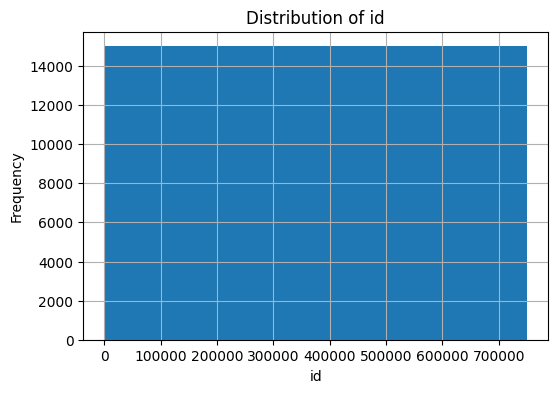

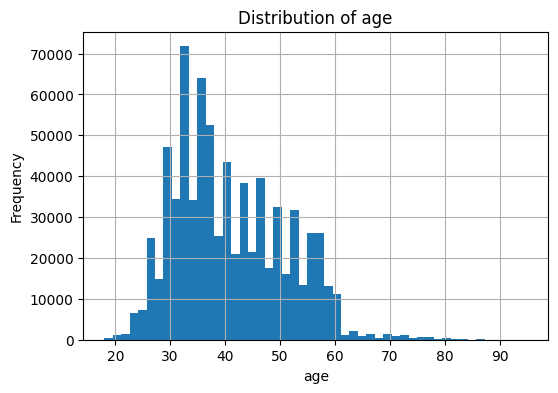

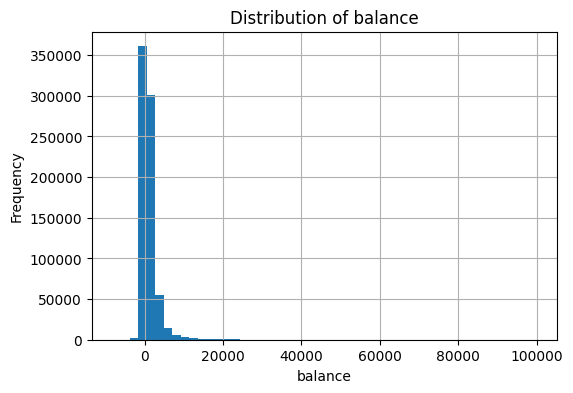

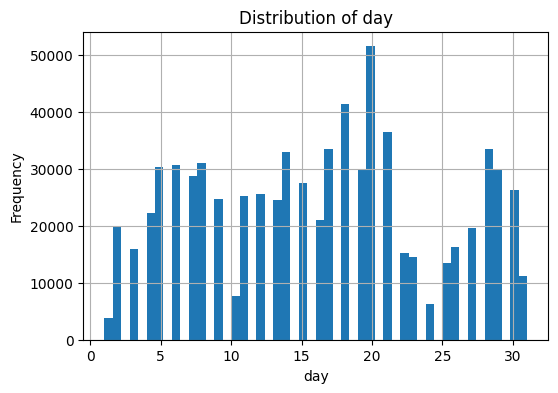

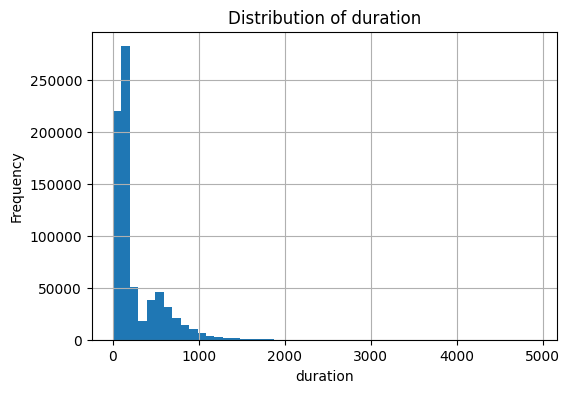

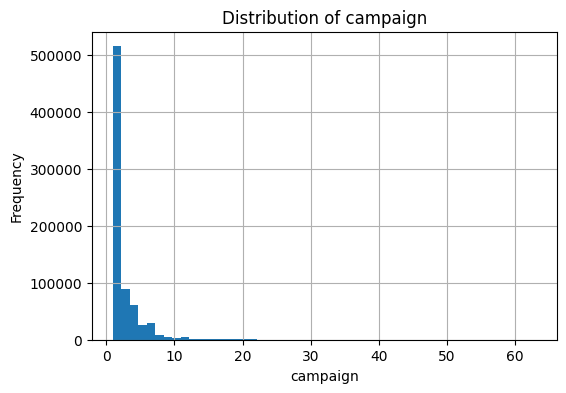

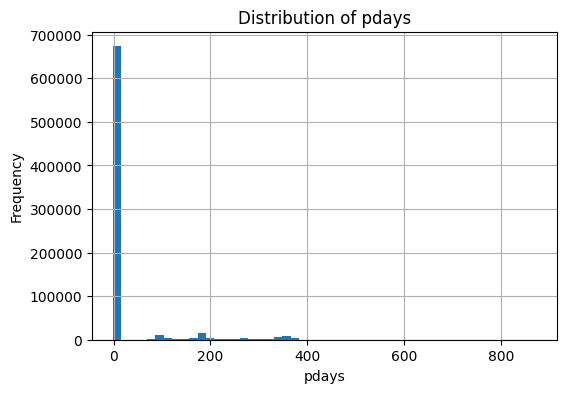

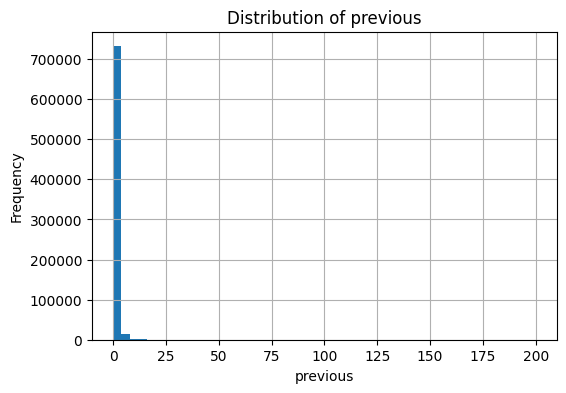

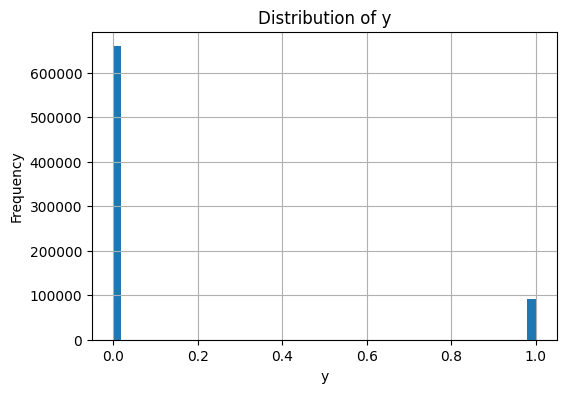

In [10]:
# Distributions of numerical columns

import matplotlib.pyplot as plt

for col in num_cols:
    plt.figure(figsize=(6,4))
    train[col].hist(bins=50)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


In [11]:
# Detect & Replace Outliers (Z-score method)

import numpy as np
from scipy import stats

# Copy dataset to avoid modifying original
train_clean = train.copy()

# Exclude 'id' column (not a feature)
num_cols = [c for c in num_cols if c != "id"]

# Set Z-score threshold
threshold = 3

for col in num_cols:
    # Calculate Z-scores
    z_scores = np.abs(stats.zscore(train_clean[col]))

    # Print how many outliers detected
    print(f"{col}: {np.sum(z_scores > threshold)} outliers detected")

    # Compute boundaries (mean ± 3*std)
    mean, std = train_clean[col].mean(), train_clean[col].std()
    upper, lower = mean + threshold * std, mean - threshold * std

    # Replace values outside boundaries with caps
    train_clean[col] = np.where(
        train_clean[col] > upper, upper,
        np.where(train_clean[col] < lower, lower, train_clean[col])
    )

print("\n✅ Outliers replaced with boundary values (capped).")


age: 4109 outliers detected
balance: 9287 outliers detected
day: 0 outliers detected
duration: 13141 outliers detected
campaign: 15045 outliers detected
pdays: 30860 outliers detected
previous: 12194 outliers detected
y: 0 outliers detected

✅ Outliers replaced with boundary values (capped).


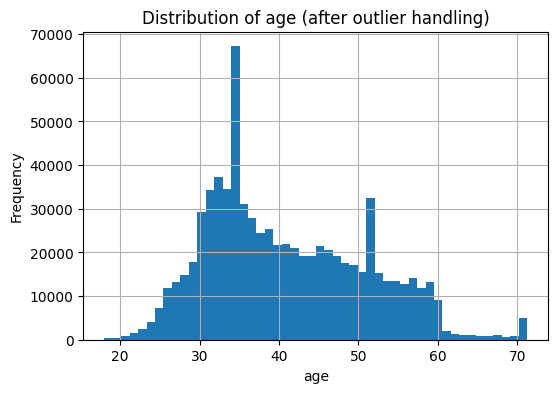

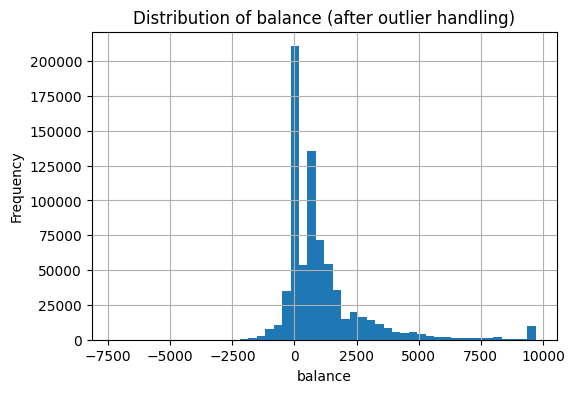

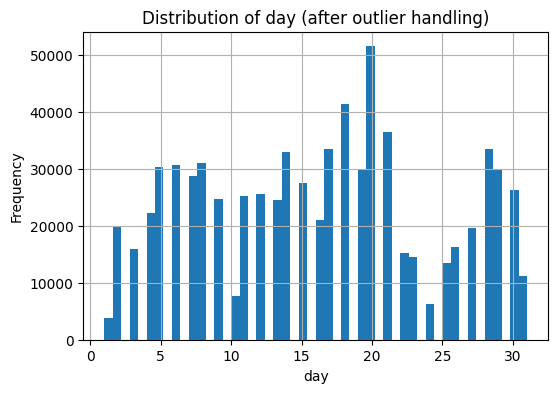

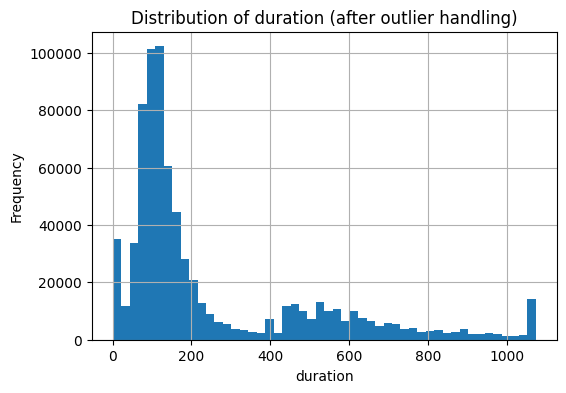

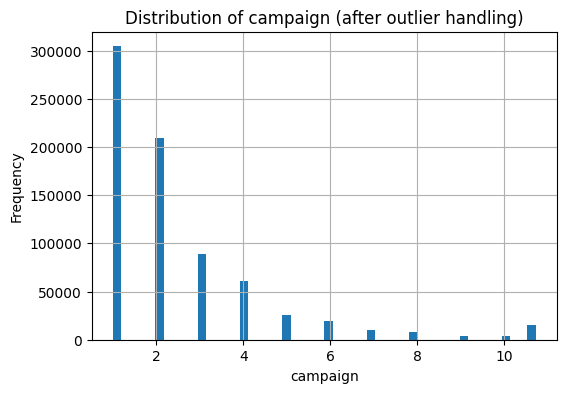

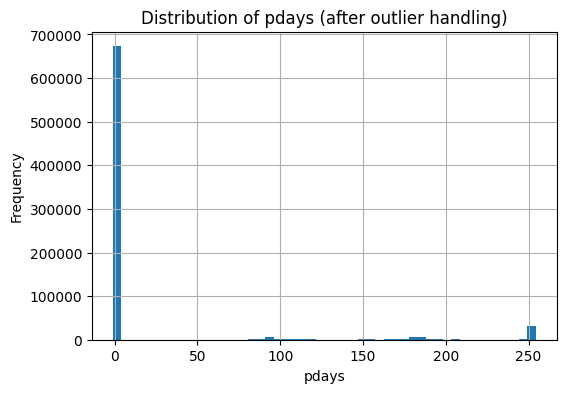

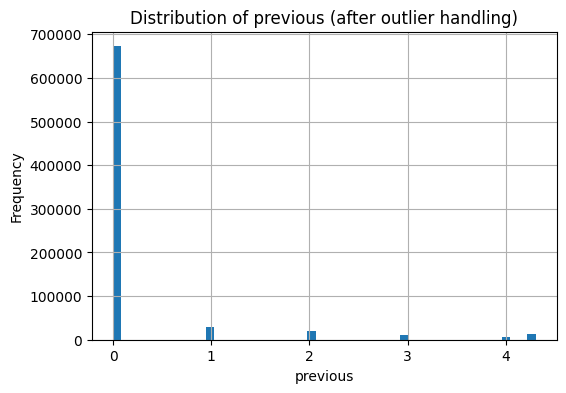

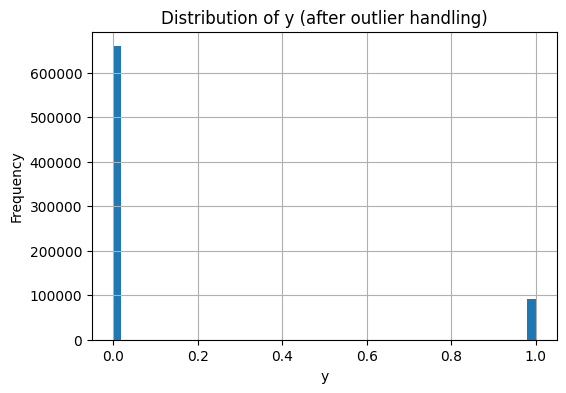

In [12]:
# Plot Distributions After Outlier Handling
import matplotlib.pyplot as plt

for col in num_cols:
    plt.figure(figsize=(6,4))
    train_clean[col].hist(bins=50)
    plt.title(f"Distribution of {col} (after outlier handling)")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


In [13]:
train

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,29,services,single,secondary,no,1282,no,yes,unknown,4,jul,1006,2,-1,0,unknown,1
749996,749996,69,retired,divorced,tertiary,no,631,no,no,cellular,19,aug,87,1,-1,0,unknown,0
749997,749997,50,blue-collar,married,secondary,no,217,yes,no,cellular,17,apr,113,1,-1,0,unknown,0
749998,749998,32,technician,married,secondary,no,-274,no,no,cellular,26,aug,108,6,-1,0,unknown,0


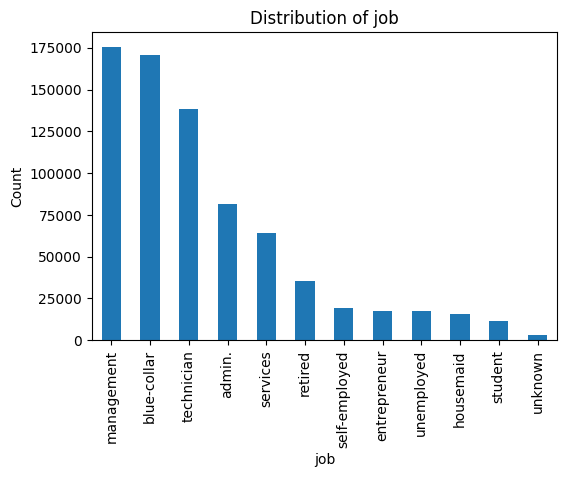

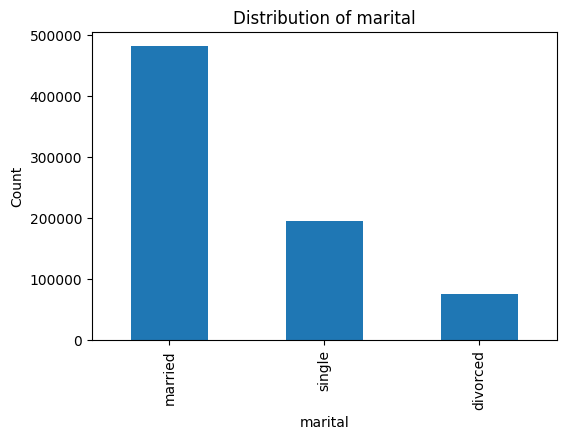

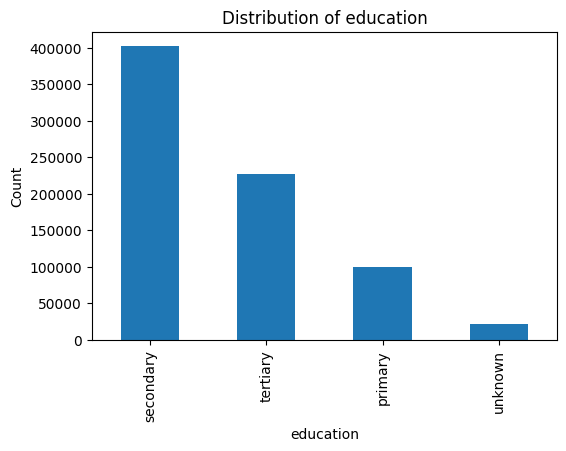

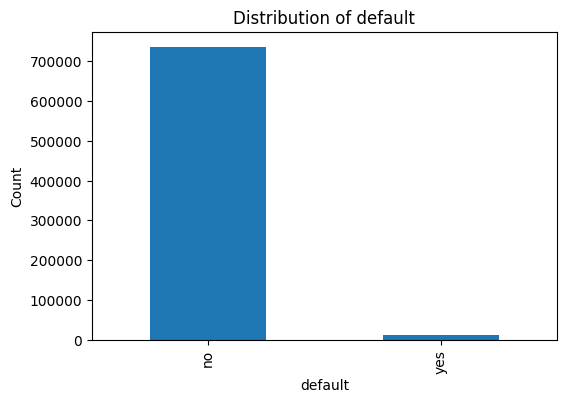

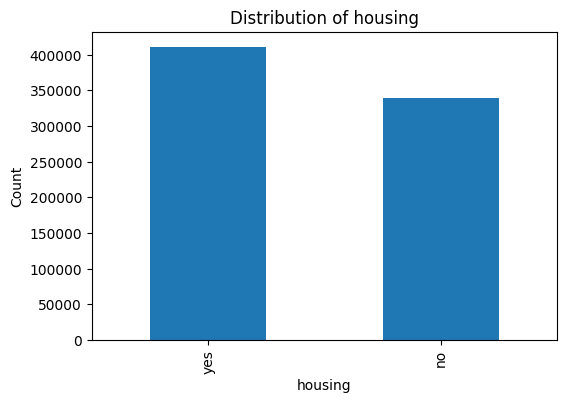

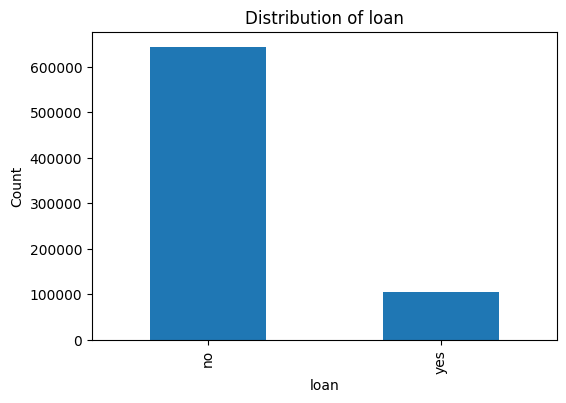

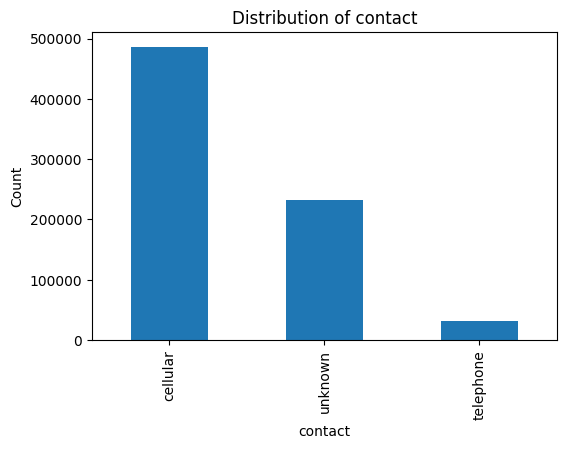

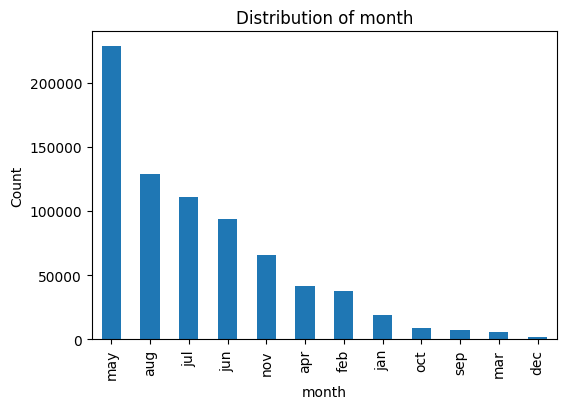

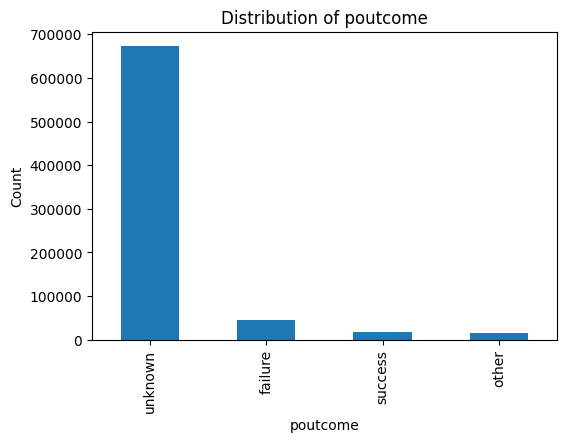

In [14]:
# Categorical value counts

for col in cat_cols:
    plt.figure(figsize=(6,4))
    train[col].value_counts().plot(kind="bar")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()


In [15]:
# category info
for col in cat_cols:
    print(f"\n---- {col} ----")
    print(train[col].value_counts())



---- job ----
job
management       175541
blue-collar      170498
technician       138107
admin.            81492
services          64209
retired           35185
self-employed     19020
entrepreneur      17718
unemployed        17634
housemaid         15912
student           11767
unknown            2917
Name: count, dtype: int64

---- marital ----
marital
married     480759
single      194834
divorced     74407
Name: count, dtype: int64

---- education ----
education
secondary    401683
tertiary     227508
primary       99510
unknown       21299
Name: count, dtype: int64

---- default ----
default
no     737151
yes     12849
Name: count, dtype: int64

---- housing ----
housing
yes    411288
no     338712
Name: count, dtype: int64

---- loan ----
loan
no     645023
yes    104977
Name: count, dtype: int64

---- contact ----
contact
cellular     486655
unknown      231627
telephone     31718
Name: count, dtype: int64

---- month ----
month
may    228411
aug    128859
jul    110647
jun  

| Column        | Categories | Suggested Encoding   | Notes                                                     |
| ------------- | ---------- | -------------------- | --------------------------------------------------------- |
| **job**       | 12         | One-Hot              | “unknown” can be treated as its own category              |
| **marital**   | 3          | One-Hot              | small, easy                                               |
| **education** | 4          | One-Hot              | keep “unknown” separate                                   |
| **default**   | 2          | Binary (yes=1, no=0) | imbalanced (mostly "no")                                  |
| **housing**   | 2          | Binary               | good candidate for 0/1                                    |
| **loan**      | 2          | Binary               | good candidate for 0/1                                    |
| **contact**   | 3          | One-Hot              | “unknown” stays as category                               |
| **month**     | 12         | One-Hot              | since there’s no strict order, better than label encoding |
| **poutcome**  | 4          | One-Hot              | “unknown” is meaningful here (most are unknown)           |


In [16]:
# Mixed Binary + One-Hot Encoding
from sklearn.preprocessing import OneHotEncoder

# Columns that are strictly binary → map directly
binary_cols = ["default", "housing", "loan"]

# for col in binary_cols:
#     train[col] = train[col].map({"no": 0, "yes": 1})
for col in binary_cols:
    train[col] = (
        train[col]
        .astype(str)          # convert to string
        .str.strip()          # remove leading/trailing spaces
        .str.lower()          # make lowercase
        .map({"no": 0, "yes": 1})
    )


# Columns that need one-hot encoding
onehot_cols = ["job", "marital", "education", "contact", "month", "poutcome"]

# Apply One-Hot
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
X_cat = encoder.fit_transform(train[onehot_cols])

print("One-hot encoded categorical shape:", X_cat.shape)


One-hot encoded categorical shape: (750000, 38)


In [17]:
print(train[binary_cols].nunique())
print(train[binary_cols].isna().sum())

print(train[binary_cols].nunique())
print(train[binary_cols].isna().sum())
print(train[binary_cols].head(10))


default    2
housing    2
loan       2
dtype: int64
default    0
housing    0
loan       0
dtype: int64
default    2
housing    2
loan       2
dtype: int64
default    0
housing    0
loan       0
dtype: int64
   default  housing  loan
0        0        0     0
1        0        0     0
2        0        1     0
3        0        1     0
4        0        1     0
5        0        1     0
6        0        0     0
7        0        0     0
8        0        0     0
9        0        1     0


In [18]:
# Numerical + Target
from sklearn.preprocessing import StandardScaler
import numpy as np

# Exclude id + target
num_features = [c for c in num_cols if c not in ["id", "y"]]

# Scale numerical features
scaler = StandardScaler()
X_num = scaler.fit_transform(train[num_features])

# Combine numerical + categorical
X = np.hstack([X_num, X_cat, train[binary_cols].values])

# Target variable
y = train["y"].values

print("Final X shape:", X.shape)
print("Final y shape:", y.shape)


Final X shape: (750000, 48)
Final y shape: (750000,)


In [19]:
# Final updated dataframe for training


# Get names for one-hot encoded columns
onehot_feature_names = encoder.get_feature_names_out(onehot_cols)

# Combine all features into a DataFrame
train_updated = pd.DataFrame(
    np.hstack([X_num, X_cat, train[binary_cols].values]),
    columns=list(num_features) + list(onehot_feature_names) + binary_cols
)

# Add target column
train_updated["y"] = y

print("Final dataframe shape:", train_updated.shape)
train_updated.head()


Final dataframe shape: (750000, 49)


,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,default,housing,loan,y
0,0.106310,-0.422083,1.076594,-0.510829,0.155597,-0.302803,-0.223475,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
1,-0.289776,-0.243316,0.228194,-0.261338,-0.580100,-0.302803,-0.223475,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,-0.487819,-0.212287,-0.256606,-0.532843,-0.212251,-0.302803,-0.223475,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
3,-1.379012,-0.412563,1.440194,-0.903409,-0.212251,-0.302803,-0.223475,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
4,-1.478033,-0.111092,-1.589805,2.369319,-0.580100,-0.302803,-0.223475,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1


In [20]:
# Model building and training part

# split + class weights

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# stratified split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(X_train.shape, X_val.shape)

# class weights to help with imbalance
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = {int(c): w for c, w in zip(classes, class_weights)}
class_weight_dict


(600000, 48) (150000, 48)


{0: np.float64(0.5686018081537499), 1: np.float64(4.144218814753419)}

In [21]:
# build the ANN
# simple, stable architecture (batchnorm + dropout). tweak widths/dropouts later.

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

tf.random.set_seed(42)


# Building the model
def build_model(input_dim: int) -> tf.keras.Model:
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(128, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Dense(32, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.AUC(name="auc", curve="ROC"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
        ],
    )
    return model

model = build_model(X.shape[1])

# Model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,537 (68.50 KB)

 Trainable params: 17,089 (66.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [22]:
# callbacks + training

es = callbacks.EarlyStopping(
    monitor="val_auc", mode="max", patience=5, restore_best_weights=True
)
rlr = callbacks.ReduceLROnPlateau(
    monitor="val_auc", mode="max", factor=0.5, patience=5, min_lr=1e-5, verbose=1
)
ckpt = callbacks.ModelCheckpoint(
    "best_ann.keras", monitor="val_auc", mode="max", save_best_only=True, verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=2048,
    class_weight=class_weight_dict,
    callbacks=[es, rlr, ckpt],
    verbose=1
)


Epoch 1/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7146 - auc: 0.8693 - loss: 0.4832 - precision: 0.2938 - recall: 0.8892
Epoch 1: val_auc improved from -inf to 0.94843, saving model to best_ann.keras
293/293 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - accuracy: 0.7148 - auc: 0.8694 - loss: 0.4829 - precision: 0.2941 - recall: 0.8893 - val_accuracy: 0.8595 - val_auc: 0.9484 - val_loss: 0.2938 - val_precision: 0.4589 - val_recall: 0.9191 - learning_rate: 0.0010
Epoch 2/50
286/293 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8433 - auc: 0.9403 - loss: 0.3018 - precision: 0.4313 - recall: 0.9293
Epoch 2: val_auc improved from 0.94843 to 0.95182, saving model to best_ann.keras
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8434 - auc: 0.9403 - loss: 0.3017 - precision: 0.4313 - recall: 0.9293 - val_accuracy: 0.8461 - val_auc: 0.9518 - val_loss: 0.2979 - val_precision: 0.4366 - val_recall: 0.9482 - learning_rate: 0.0010
Epoch 3/50
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

In [23]:
# save the model
model.save("ann_v1.h5")  # or .keras

In [24]:
# evaluation

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# best model is already restored by EarlyStopping
val_pred_proba = model.predict(X_val, verbose=0).ravel()
val_pred = (val_pred_proba >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_val, val_pred_proba))
print(classification_report(y_val, val_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_val, val_pred))


ROC-AUC: 0.9632010152944784
              precision    recall  f1-score   support

           0     0.9903    0.8688    0.9256    131902
           1     0.4952    0.9381    0.6482     18098

    accuracy                         0.8772    150000
   macro avg     0.7428    0.9035    0.7869    150000
weighted avg     0.9306    0.8772    0.8921    150000

Confusion matrix:
 [[114595  17307]
 [  1120  16978]]


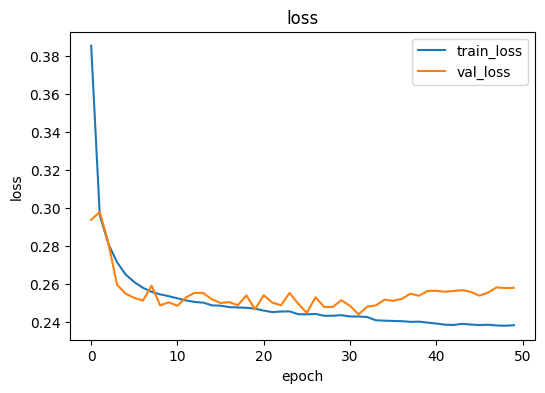

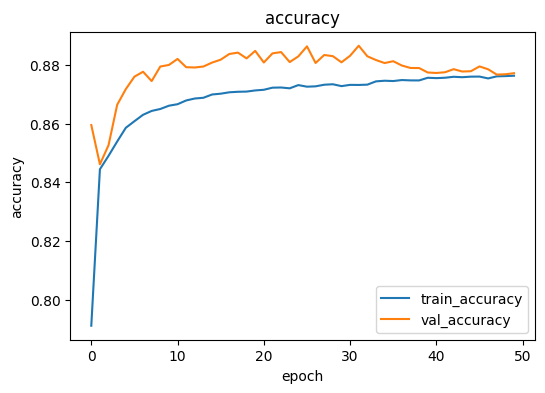

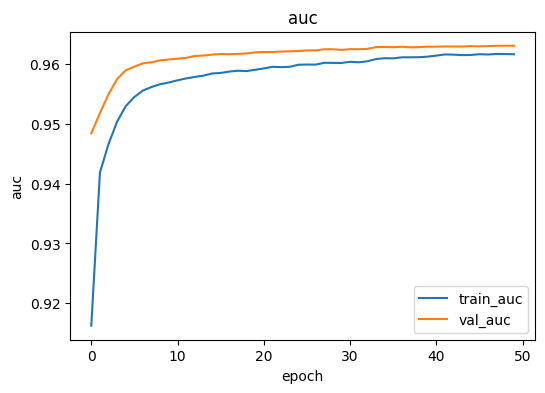

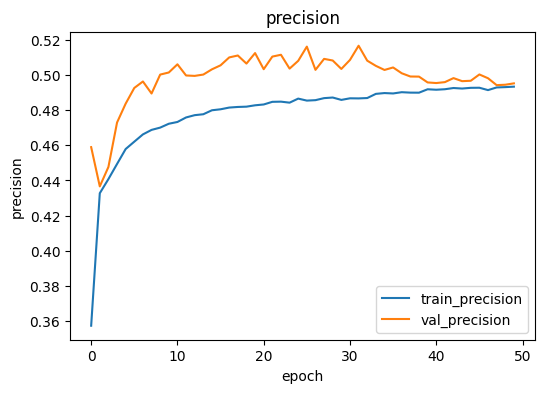

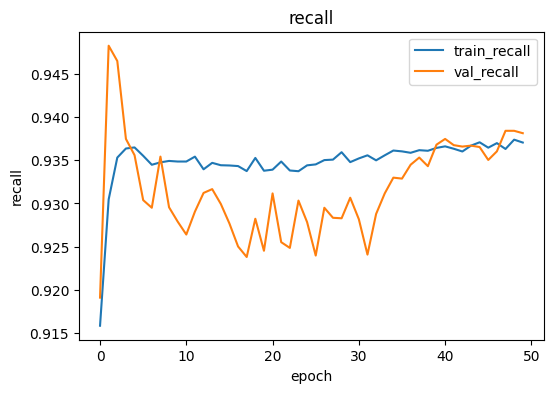

In [25]:
# plot training curves

import matplotlib.pyplot as plt

def plot_hist(h, key):
    plt.figure(figsize=(6,4))
    plt.plot(h.history[key], label=f"train_{key}")
    plt.plot(h.history[f"val_{key}"], label=f"val_{key}")
    plt.title(key)
    plt.xlabel("epoch"); plt.ylabel(key)
    plt.legend(); plt.show()

for k in ["loss", "accuracy", "auc", "precision", "recall"]:
    if k in history.history:
        plot_hist(history, k)


In [26]:
# test predictions (no labels)

# numeric
X_test_num = scaler.transform(test[num_features])

# binary yes/no → 0/1
test_bin = test[binary_cols].replace({"no": 0, "yes": 1}).values

# one-hot categorical
X_test_cat = encoder.transform(test[onehot_cols])

# final test design matrix
X_test = np.hstack([X_test_num, X_test_cat, test_bin])

# predict probabilities
test_proba = model.predict(X_test, verbose=0).ravel()

# if competition wants 0/1 instead of probabilities:
test_pred = (test_proba >= 0.5).astype(int)

# build dataframe
submission = pd.DataFrame({
    "id": test["id"],
    "y": test_proba   # or test_pred
})
submission.to_csv("ann-v1-submission.csv", index=False)


/tmp/ipython-input-1323043001.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_bin = test[binary_cols].replace({"no": 0, "yes": 1}).values


ANN v2

In [27]:
# ANN v2: deeper, GELU, L2 regularization, tuned dropout + batch size

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers

tf.random.set_seed(42)


# Build improved ANN
def build_model(input_dim: int) -> tf.keras.Model:
    inputs = layers.Input(shape=(input_dim,))

    x = layers.Dense(
        256, activation="gelu",
        kernel_regularizer=regularizers.l2(1e-5)
    )(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Dense(
        128, activation="gelu",
        kernel_regularizer=regularizers.l2(1e-5)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(
        64, activation="gelu",
        kernel_regularizer=regularizers.l2(1e-5)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.15)(x)

    x = layers.Dense(
        32, activation="gelu",
        kernel_regularizer=regularizers.l2(1e-5)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.AUC(name="auc", curve="ROC"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
        ],
    )
    return model

In [28]:
# Build model
model = build_model(X.shape[1])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,729 (225.50 KB)

 Trainable params: 56,769 (221.75 KB)

 Non-trainable params: 960 (3.75 KB)

In [29]:
# Callbacks
es = callbacks.EarlyStopping(
    monitor="val_auc", mode="max", patience=5, restore_best_weights=True
)
rlr = callbacks.ReduceLROnPlateau(
    monitor="val_auc", mode="max", factor=0.5, patience=5, min_lr=1e-5, verbose=1
)
ckpt = callbacks.ModelCheckpoint(
    "best_ann_v2.keras", monitor="val_auc", mode="max", save_best_only=True, verbose=1
)

In [30]:
# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=1024,  # smaller than before for better generalization
    class_weight=class_weight_dict,
    callbacks=[es, rlr, ckpt],
    verbose=1
)


Epoch 1/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8182 - auc: 0.9229 - loss: 0.3760 - precision: 0.3954 - recall: 0.9115
Epoch 1: val_auc improved from -inf to 0.95635, saving model to best_ann_v2.keras
586/586 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.8183 - auc: 0.9229 - loss: 0.3759 - precision: 0.3954 - recall: 0.9115 - val_accuracy: 0.8817 - val_auc: 0.9564 - val_loss: 0.2550 - val_precision: 0.5054 - val_recall: 0.9111 - learning_rate: 0.0010
Epoch 2/50
580/586 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8585 - auc: 0.9512 - loss: 0.2749 - precision: 0.4580 - recall: 0.9300
Epoch 2: val_auc improved from 0.95635 to 0.95911, saving model to best_ann_v2.keras
586/586 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.8585 - auc: 0.9512 - loss: 0.2749 - precision: 0.4580 - recall: 0.9300 - val_accuracy: 0.8777 - val_auc: 0.9591 - val_loss: 0.2660 - val_precision: 0.4963 - val_recall: 0.9274 - learning_rate: 0.0010
Epoch 3/50
574/586 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

In [31]:
# save the model
model.save("ann_v2.h5")  # or .keras

ROC-AUC: 0.9637150253601767
              precision    recall  f1-score   support

           0     0.9896    0.8756    0.9291    131902
           1     0.5071    0.9330    0.6571     18098

    accuracy                         0.8825    150000
   macro avg     0.7484    0.9043    0.7931    150000
weighted avg     0.9314    0.8825    0.8963    150000

Confusion matrix:
 [[115490  16412]
 [  1213  16885]]


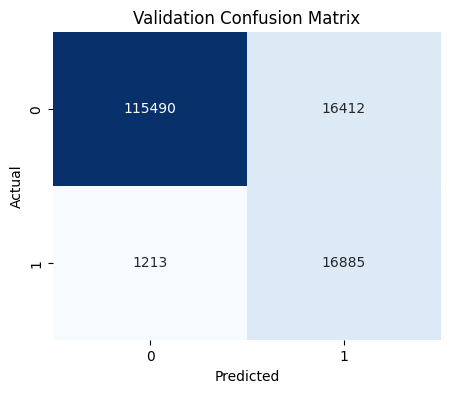

In [32]:
# =======================
# 📊 Model Evaluation
# =======================
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Validation predictions
val_pred_proba = model.predict(X_val, verbose=0).ravel()
val_pred = (val_pred_proba >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_val, val_pred_proba))
print(classification_report(y_val, val_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_val, val_pred))

# 🔹 Plot Confusion Matrix
cm = confusion_matrix(y_val, val_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

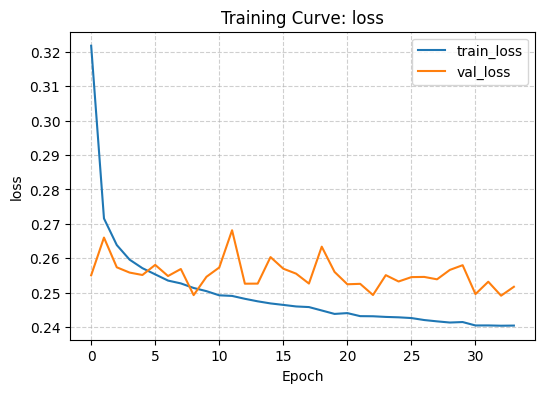

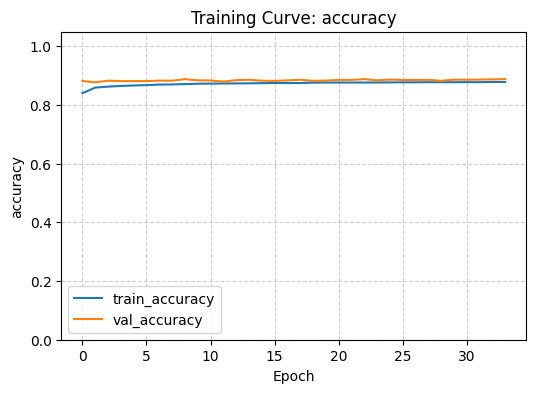

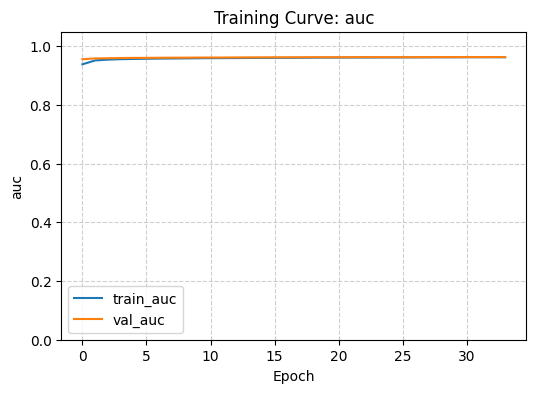

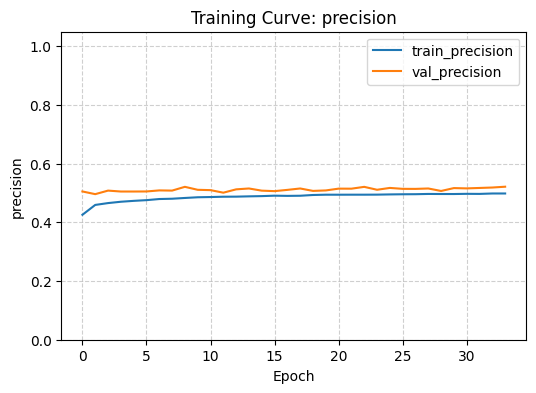

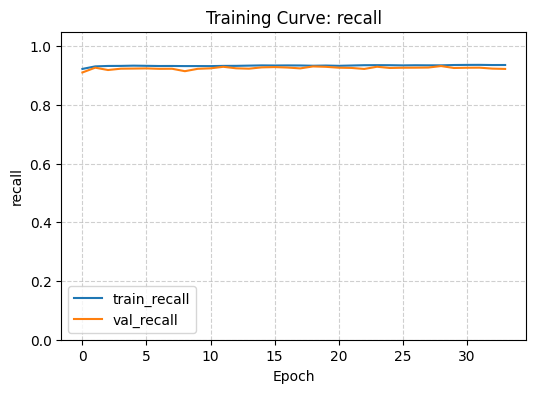

In [33]:
# =======================
# 📈 Training Curves
# =======================
def plot_hist(h, key, ymax=None):
    plt.figure(figsize=(6,4))
    plt.plot(h.history[key], label=f"train_{key}")
    plt.plot(h.history[f"val_{key}"], label=f"val_{key}")
    plt.title(f"Training Curve: {key}")
    plt.xlabel("Epoch")
    plt.ylabel(key)
    if ymax: plt.ylim(0, ymax)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

for k in ["loss", "accuracy", "auc", "precision", "recall"]:
    if k in history.history:
        ymax = 1.05 if k != "loss" else None
        plot_hist(history, k, ymax)


In [34]:
# =======================
# 📝 Test Predictions
# =======================
# Numeric features
X_test_num = scaler.transform(test[num_features])

# Binary yes/no → 0/1
test_bin = test[binary_cols].replace({"no": 0, "yes": 1}).values

# One-hot categorical (same encoder as training)
X_test_cat = encoder.transform(test[onehot_cols])

# Final design matrix
X_test = np.hstack([X_test_num, X_test_cat, test_bin])

# Predict
test_proba = model.predict(X_test, verbose=0).ravel()
test_pred = (test_proba >= 0.5).astype(int)

# Build submission
submission = pd.DataFrame({
    "id": test["id"],
    "y": test_proba   # use probabilities (most competitions want this)
})
submission.to_csv("submission_updated.csv", index=False)

print("✅ Submission saved as submission_updated.csv")


/tmp/ipython-input-3066071561.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_bin = test[binary_cols].replace({"no": 0, "yes": 1}).values


✅ Submission saved as submission_updated.csv


Lets try with lightGBM and XGboost

In [42]:
# ==================== LIGHTGBM BASELINE ==================== #
import lightgbm as lgb
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier, early_stopping, log_evaluation


# Initialize model
lgb_model = lgb.LGBMClassifier(
        objective="binary",
        metric="auc",
        n_estimators=20000,
        learning_rate=0.04,
        num_leaves=110,
        max_depth=15,
        min_child_samples=7,
        subsample=0.75,
        colsample_bytree=0.30,
        reg_alpha=1.5,
        reg_lambda=1.85,
        max_bin=3927,
        random_state=42
    )

# Fit with callbacks for early stopping + logging
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="auc",
    callbacks=[early_stopping(stopping_rounds=50), log_evaluation(100)]
)

[LightGBM] [Info] Number of positive: 72390, number of negative: 527610
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1036
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120650 -> initscore=-1.986289
[LightGBM] [Info] Start training from score -1.986289
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.96243	valid_0's binary_logloss: 0.157293
[200]	valid_0's auc: 0.965548	valid_0's binary_logloss: 0.150097
[300]	valid_0's auc: 0.966528	valid_0's binary_logloss: 0.148063
[400]	valid_0's auc: 0.967009	valid_0's binary_logloss: 0.146945
[500]	valid_0's auc: 0.967397	valid_0's binary_logloss: 0.146074
[600]	valid_0's auc: 0.967661	valid_0's binary_logloss: 0.145502
[700]	valid_0's auc: 0.967846	valid_0's binary_logloss

LGBMClassifier(colsample_bytree=0.9, learning_rate=0.05, n_estimators=1000,
               objective='binary', random_state=42, subsample=0.8)

In [43]:
# Predictions (use best_iteration_ from early stopping)
lgb_y_val_pred_proba = lgb_model.predict_proba(X_val, num_iteration=lgb_model.best_iteration_)[:, 1]

lgb_y_val_pred = (lgb_y_val_pred_proba >= 0.5).astype(int)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [44]:
# Evaluation
print("\nLIGHTGBM CLASSIFICATION REPORT:")
print(classification_report(y_val, lgb_y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, lgb_y_val_pred_proba))


LIGHTGBM CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96    131902
           1       0.77      0.68      0.72     18098

    accuracy                           0.94    150000
   macro avg       0.86      0.83      0.84    150000
weighted avg       0.93      0.94      0.93    150000

ROC-AUC: 0.9682105171700266


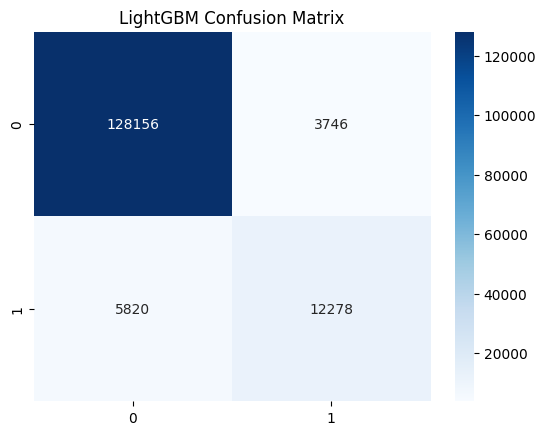

In [45]:
# Confusion matrix
sns.heatmap(confusion_matrix(y_val, lgb_y_val_pred), annot=True, fmt="d", cmap="Blues")
plt.title("LightGBM Confusion Matrix")
plt.show()

In [47]:
# Submission
lgb_test_pred_proba = lgb_model.predict_proba(
    X_test,
    num_iteration=lgb_model.best_iteration_
)[:, 1]

submission["Response"] = lgb_test_pred_proba
submission.to_csv("submission_lgb.csv", index=False)
print("LightGBM submission saved as submission_lgb.csv")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM submission saved as submission_lgb.csv


In [59]:
# ==================== XGBOOST BASELINE (old XGBoost version) ==================== #
import xgboost as xgb
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to DMatrix (required for xgb.train)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.01,
    "max_depth": 9,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42
}

# Train with early stopping
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, "train"), (dval, "val")],
    early_stopping_rounds=50,
    verbose_eval=100
)

[0]	train-auc:0.93349	val-auc:0.93393
[100]	train-auc:0.96085	val-auc:0.96007
[200]	train-auc:0.96541	val-auc:0.96378
[300]	train-auc:0.96769	val-auc:0.96525
[400]	train-auc:0.96919	val-auc:0.96603
[500]	train-auc:0.97036	val-auc:0.96653
[600]	train-auc:0.97137	val-auc:0.96692
[700]	train-auc:0.97221	val-auc:0.96722
[800]	train-auc:0.97296	val-auc:0.96740
[900]	train-auc:0.97360	val-auc:0.96756
[999]	train-auc:0.97425	val-auc:0.96766


In [63]:
# ==================== PREDICTIONS ==================== #
# Convert validation set to DMatrix
dval = xgb.DMatrix(X_val)

# Probabilities (direct output)
xgb_y_val_pred_proba = xgb_model.predict(
    dval,
    iteration_range=(0, xgb_model.best_iteration + 1)  # use best iteration from early stopping
)

# Binary predictions
xgb_y_val_pred = (xgb_y_val_pred_proba >= 0.5).astype(int)


In [64]:
# Evaluation
print("\nXGBOOST CLASSIFICATION REPORT:")
print(classification_report(y_val, xgb_y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, xgb_y_val_pred_proba))


XGBOOST CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96    131902
           1       0.77      0.67      0.71     18098

    accuracy                           0.94    150000
   macro avg       0.86      0.82      0.84    150000
weighted avg       0.93      0.94      0.93    150000

ROC-AUC: 0.9676628273680296


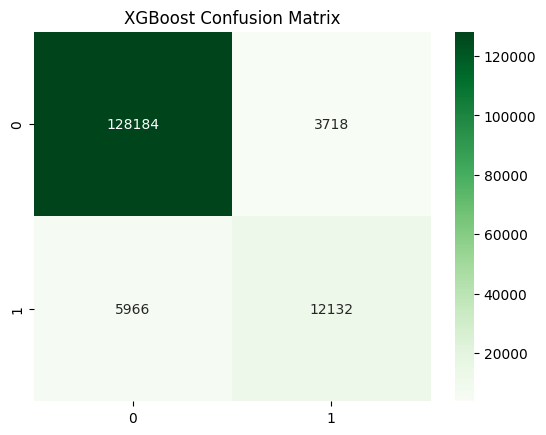

In [65]:
# Confusion matrix
sns.heatmap(confusion_matrix(y_val, xgb_y_val_pred), annot=True, fmt="d", cmap="Greens")
plt.title("XGBoost Confusion Matrix")
plt.show()

In [67]:
# ==================== SUBMISSION ==================== #
dtest = xgb.DMatrix(X_test)

xgb_test_pred_proba = xgb_model.predict(
    dtest,
    iteration_range=(0, xgb_model.best_iteration + 1)  # same fix as validation
)

submission["Response"] = xgb_test_pred_proba
submission.to_csv("submission_xgb.csv", index=False)
print("XGBoost submission saved as submission_xgb.csv")


XGBoost submission saved as submission_xgb.csv


with GridSearchCV for finding optimal value

In [69]:
# # ==================== LIGHTGBM BASELINE (with GridSearchCV) ==================== #
# import lightgbm as lgb
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Define base model
# lgb_model = lgb.LGBMClassifier(
#     objective="binary",
#     metric="auc",
#     boosting_type="gbdt",
#     random_state=42,
#     n_jobs=-1
# )

# # Parameter grid for tuning
# lgb_param_grid = {
#     "n_estimators": [10000, 150000, 20000],
#     "learning_rate": [0.01, 0.05, 0.04],
#     "num_leaves": [110, 100, 120],
#     "max_depth": [15, 20, 10],
#     "subsample": [0.7, 0.8, 0.6],
#     "colsample_bytree": [0.3, 0.4, 0.5]
# }

# # Grid search
# grid_lgb = GridSearchCV(
#     estimator=lgb_model,
#     param_grid=lgb_param_grid,
#     scoring="roc_auc",
#     cv=3,
#     verbose=2,
#     n_jobs=-1
# )

# grid_lgb.fit(X_train, y_train)

# print("Best LGBM params:", grid_lgb.best_params_)
# print("Best CV AUC:", grid_lgb.best_score_)

# # Retrain on training data with best params
# best_lgb = grid_lgb.best_estimator_
# best_lgb.fit(X_train, y_train)

# # Predictions
# lgb_y_val_pred_proba = best_lgb.predict_proba(X_val)[:, 1]
# lgb_y_val_pred = (lgb_y_val_pred_proba >= 0.5).astype(int)

# # Evaluation
# print("\nLIGHTGBM CLASSIFICATION REPORT (Best Params):")
# print(classification_report(y_val, lgb_y_val_pred))
# print("Validation ROC-AUC:", roc_auc_score(y_val, lgb_y_val_pred_proba))

# # Confusion matrix
# sns.heatmap(confusion_matrix(y_val, lgb_y_val_pred), annot=True, fmt="d", cmap="Blues")
# plt.title("LightGBM (Tuned) Confusion Matrix")
# plt.show()

# # Test predictions for submission
# lgb_test_pred_proba = best_lgb.predict_proba(X_test)[:, 1]
# submission["Response"] = lgb_test_pred_proba
# submission.to_csv("submission_lgb_tuned.csv", index=False)
# print("LightGBM tuned submission saved as submission_lgb_tuned.csv")


In [70]:
# # ==================== XGBOOST WITH GRIDSEARCHCV ==================== #
# from xgboost import XGBClassifier
# from sklearn.model_selection import GridSearchCV

# # Define parameter grid for XGBoost
# param_grid = {
#     "n_estimators": [20000, 30000, 10000],   # number of boosting rounds
#     "learning_rate": [0.01, 0.02, 0.03], # step size shrinkage
#     "max_depth": [8, 7, 9],             # tree depth
#     "subsample": [0.7, 0.8, 0.9],       # row sampling
#     "colsample_bytree": [0.7, 0.8, 0.9] # feature sampling
# }

# # Base model
# xgb_base = XGBClassifier(
#     objective="binary:logistic",
#     eval_metric="auc",
#     use_label_encoder=False,
#     random_state=42,
#     n_jobs=-1
# )

# # GridSearchCV
# grid_xgb = GridSearchCV(
#     estimator=xgb_base,
#     param_grid=param_grid,
#     scoring="roc_auc",   # optimize for AUC
#     cv=3,                # 3-fold CV
#     verbose=2,           # show progress
#     n_jobs=-1            # parallel jobs
# )

# # Fit GridSearchCV
# grid_xgb.fit(X_train, y_train)

# # Best parameters
# print("Best XGBoost Params:", grid_xgb.best_params_)
# print("Best XGBoost CV Score (AUC):", grid_xgb.best_score_)

# # Evaluate on validation set
# best_xgb = grid_xgb.best_estimator_
# val_pred_proba = best_xgb.predict_proba(X_val)[:, 1]
# val_pred = (val_pred_proba >= 0.5).astype(int)

# from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
# print("Validation ROC-AUC:", roc_auc_score(y_val, val_pred_proba))
# print(classification_report(y_val, val_pred, digits=4))
# print("Confusion Matrix:\n", confusion_matrix(y_val, val_pred))
